In [63]:
import gym
from gym import spaces
import numpy as np
import math

In [99]:
class ClassificationEnv(gym.Env):
    def __init__(self, df):
        super(ClassificationEnv, self).__init__()
        self.df = df
        self.current_state = None
        self.action_space = gym.spaces.Discrete(3)

    def reset(self):
        self.current_state = self.df.sample(1)
        return self.current_state[['ri', 'ci', 'intensity']].values

    def step(self, action):
        chosen_class = ['memory', 'io', 'cpu'][action]
        true_class = self.current_state['type'].iloc[0]
        action_probs = torch.softmax(actor(torch.FloatTensor(self.current_state[['ri', 'ci', 'intensity']].values).to(device)), dim=-1)
        predicted_prob = action_probs[0, action].item()
        def confidence_to_reward(confidence):
            return 1 / (1 + math.exp(-10*(confidence-0.5)))
        reward = confidence_to_reward(predicted_prob) if chosen_class == true_class else -confidence_to_reward(predicted_prob)
        done = True
        return self.current_state[['ri', 'ci', 'intensity']].values, reward, done, {}

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim

In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training")

Using cuda for training


In [102]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc = nn.Linear(3, 1)

    def forward(self, state):
        return self.fc(state.to(device))

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc = nn.Linear(3, 3)

    def forward(self, state):
        return self.fc(state.to(device))

In [103]:
class ActorCriticAgent:
    def __init__(self, actor, critic, actor_optimizer, critic_optimizer, gamma):
        self.actor = actor
        self.critic = critic
        self.actor_optimizer = actor_optimizer
        self.critic_optimizer = critic_optimizer
        self.gamma = gamma

    def choose_action(self, state):
        state = torch.FloatTensor(state)
        action_probs = torch.softmax(self.actor(state), dim=-1)
        action = torch.multinomial(action_probs, 1).item()
        return action

    def update(self, state, action, next_state, reward):
        state = torch.FloatTensor(state).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        target_value = reward + self.gamma * self.critic(next_state)
        critic_value = self.critic(state)
        critic_loss = nn.MSELoss()(critic_value, target_value.detach())

        self.critic_optimizer.zero_grad()
        critic_loss.backward(retain_graph=True)
        self.critic_optimizer.step()

        action_log_probs = torch.log_softmax(self.actor(state), dim=-1)
        action_loss = -action_log_probs[0, action] * (target_value - critic_value)

        self.actor_optimizer.zero_grad()
        action_loss.backward()
        self.actor_optimizer.step()

In [104]:
def compute_critic_loss(reward, next_state, critic):
    target_value = reward + agent.gamma * critic(next_state)
    critic_value = critic(state)
    return nn.MSELoss()(critic_value, target_value.detach())

def compute_actor_loss(state, action, advantage, actor):
    action_prob = torch.softmax(actor(state), dim=-1)[action]
    return -(advantage * action_prob * state)

def compute_advantage(reward, next_state, critic):
    target_value = reward + agent.gamma * critic(next_state)
    critic_value = critic(state)
    return target_value - critic_value

In [105]:
import pandas as pd

In [106]:
dataset1 = pd.read_csv('anomaly_svm.csv')
dataset2 = pd.read_csv('injection_prediction.csv')

In [107]:
dataset = pd.concat([dataset1, dataset2], ignore_index = True)
dataset = dataset.drop(columns = ['localization', 'anomaly']).drop_duplicates()
dataset = dataset.sample(frac = 1).reset_index(drop = True)

In [108]:
env = ClassificationEnv(dataset)

In [109]:
actor = Actor().to(device)
critic = Critic().to(device)

In [110]:
actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)
agent = ActorCriticAgent(actor, critic, actor_optimizer, critic_optimizer, gamma=0.9)
num_episodes = 1000

In [111]:
total_reward_list = []

In [112]:
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, next_state, reward)

        state = next_state
        total_reward += reward

    total_reward_list.append(total_reward)

    # print(f"Episode {episode}, Total Reward: {total_reward}")

In [113]:
import matplotlib.pyplot as plt

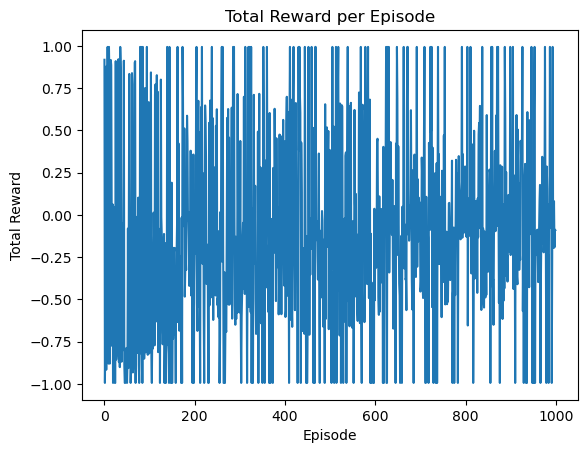

In [116]:
plt.plot(range(num_episodes), total_reward_list)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.savefig('reward.png')
plt.show()